# Recommender Systems

## Import Libraries

In [110]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Get the Data

In [111]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=column_names) # There are no column names in the data. So we create them.

In [112]:
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [113]:
df.shape

(100003, 4)

Now let's get the movie titles:

In [114]:
movie_titles = pd.read_csv("Movie_Id_Titles")
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [115]:
movie_titles.shape

(1682, 2)

We can merge them together:

In [116]:
df = pd.merge(df,movie_titles,on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


# EDA
## Visualization Imports

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

Let's create a ratings dataframe with average rating and number of ratings:

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100003 entries, 0 to 100002
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    100003 non-null  int64 
 1   item_id    100003 non-null  int64 
 2   rating     100003 non-null  int64 
 3   timestamp  100003 non-null  int64 
 4   title      100003 non-null  object
dtypes: int64(4), object(1)
memory usage: 4.6+ MB


In [119]:
df.isnull().sum()

user_id      0
item_id      0
rating       0
timestamp    0
title        0
dtype: int64

In [120]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).sample(5)

title
Grosse Fatigue (1994)                           3.250000
Rosencrantz and Guildenstern Are Dead (1990)    3.888889
Halloween: The Curse of Michael Myers (1995)    2.200000
Paris Is Burning (1990)                         3.814815
City of Industry (1997)                         2.500000
Name: rating, dtype: float64

In [121]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

In [122]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


Now set the number of ratings column:

In [123]:
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


In [124]:
ratings['timestamp'] = pd.DataFrame(df.groupby('title')['timestamp'].max())
ratings.head()

,rating,num of ratings,timestamp
title,,,
'Til There Was You (1997),2.333333,9,891550470
1-900 (1994),2.600000,5,885549745
101 Dalmatians (1996),2.908257,109,893264703
12 Angry Men (1957),4.344000,125,893265191
187 (1997),3.024390,41,892871372


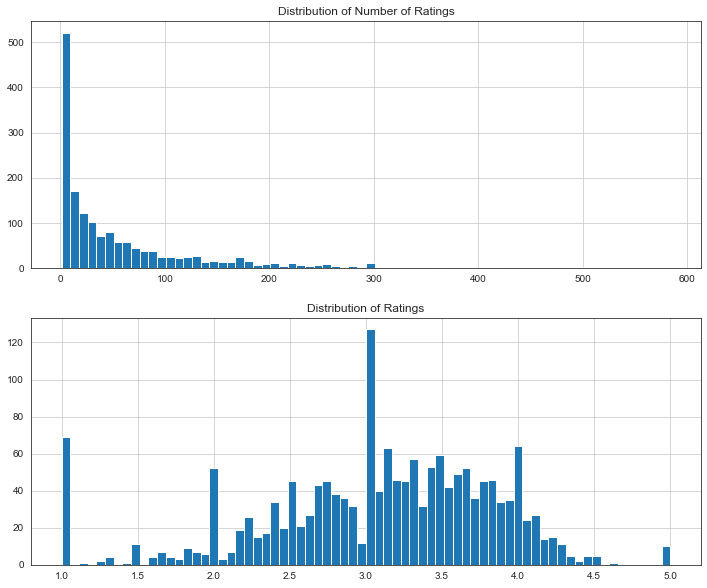

In [125]:
plt.figure(figsize=(12,10))
plt.subplot(211)
plt.title("Distribution of Number of Ratings")
ratings['num of ratings'].hist(bins=70)
plt.subplot(212)
plt.title("Distribution of Ratings")
ratings['rating'].hist(bins=70)
plt.show()

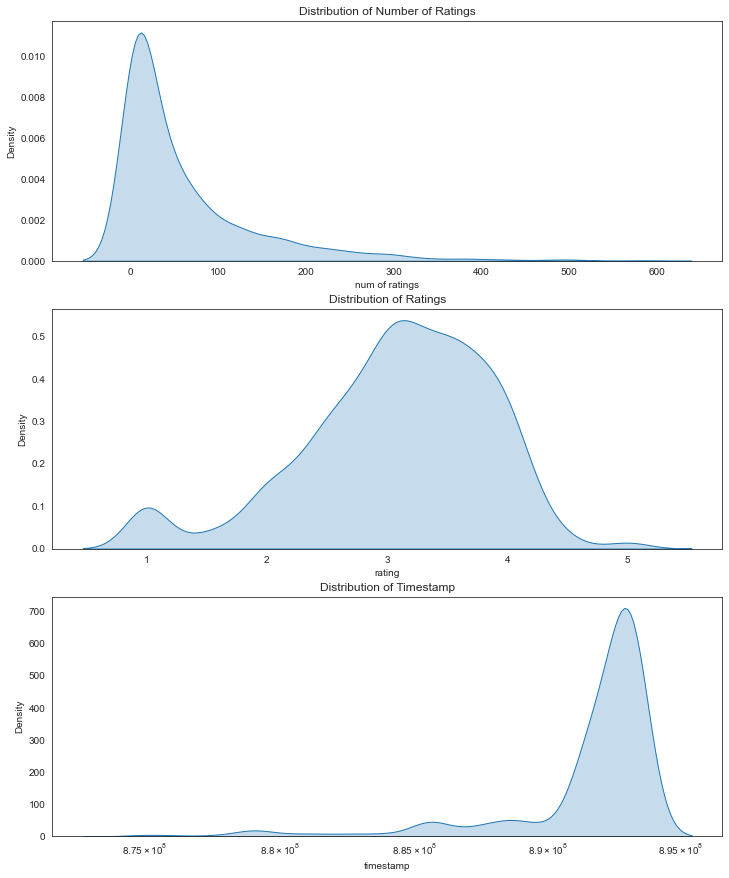

In [145]:
# Alternative
plt.figure(figsize=(12,15))
plt.subplot(311)
plt.title("Distribution of Number of Ratings")
sns.kdeplot(data=ratings['num of ratings'], shade=True)

plt.subplot(312)
plt.title("Distribution of Ratings")
sns.kdeplot(data=ratings.rating, shade=True)

plt.subplot(313)
plt.title("Distribution of Timestamp")
sns.kdeplot(data=ratings.timestamp, shade=True,log_scale=True)
plt.show()

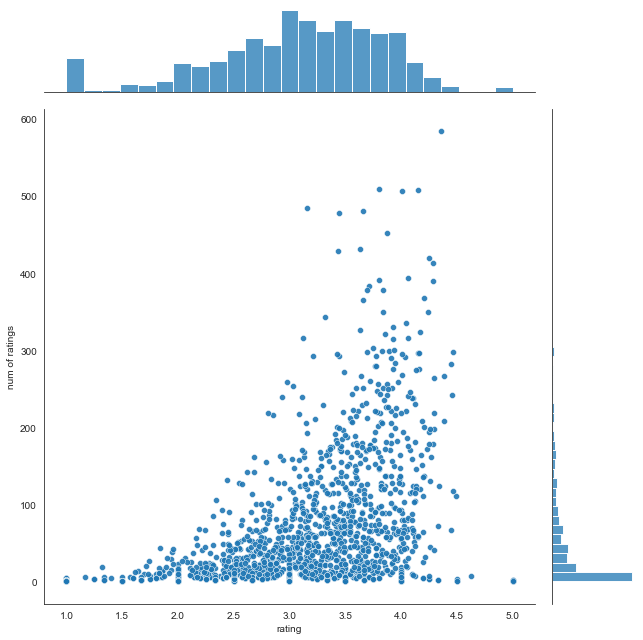

In [152]:
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.9,height=9)
plt.show()

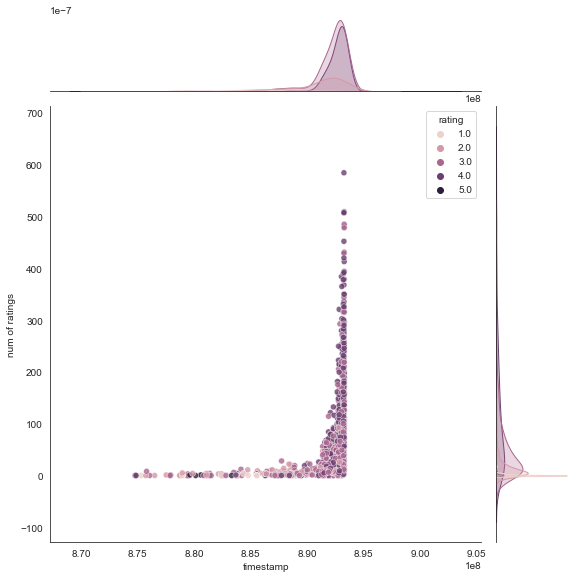

In [154]:
sns.jointplot(x='timestamp',y='num of ratings',data=ratings,hue=round(ratings['rating']),alpha=0.8,height=8)
plt.show()

## Recommending Similar Movies

* Now let's create a matrix that has the user ids on one access and the movie title on another axis. 
* Each cell will then consist of the rating the user gave to that movie. Note there will be a lot of NaN values, because most people have not seen most of the movies.
* Önce, bir eksende kullanıcı kimliklerinin ve diğer eksende film adlarının olduğu bir matris oluşturacağız. Boylece filmlerin birbiriyle arasinda korelasyona erismeye calisacagiz. Original data frame'den sadece filmin adı, kullanıcı kimliği ve filmin derecelendirmesiyle ilgileniyoruz.
* Kullanıcıların (user ID) filmlere verdikleri gerçek derecelendirmeye sahip Pivot Table olusturup, aradan filmeler secip, o filmlerle benzer filmeri modele buldurmaya calisacagiz.


In [155]:
movie_matrix = df.pivot_table(index='user_id',columns='title',values='rating')
movie_matrix.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [156]:
movie_matrix.shape

(944, 1664)

Most rated movie:

In [157]:
ratings.sort_values('num of ratings',ascending=False).head(10)

,rating,num of ratings,timestamp
title,,,
Star Wars (1977),4.359589,584,893263994
Contact (1997),3.803536,509,893282978
Fargo (1996),4.155512,508,893263994
Return of the Jedi (1983),4.007890,507,893264023
Liar Liar (1997),3.156701,485,893286346
"English Patient, The (1996)",3.656965,481,893282977
Scream (1996),3.441423,478,893286261
Toy Story (1995),3.878319,452,893264174
Air Force One (1997),3.631090,431,893286638


Let's choose two movies: starwars, a sci-fi movie. And Liar Liar, a comedy.

In [161]:
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


Now let's grab the user ratings for those two movies:

In [158]:
starwars_user_ratings = movie_matrix['Star Wars (1977)']
liarliar_user_ratings = movie_matrix['Liar Liar (1997)']
starwars_user_ratings.head()

user_id
0    5.0
1    5.0
2    5.0
3    NaN
4    5.0
Name: Star Wars (1977), dtype: float64

We can then use corrwith() method to get correlations between two pandas series:

In [160]:
similar_to_starwars = movie_matrix.corrwith(starwars_user_ratings)
similar_to_liarliar = movie_matrix.corrwith(liarliar_user_ratings)

In [161]:
similar_to_starwars

title
'Til There Was You (1997)                0.872872
1-900 (1994)                            -0.645497
101 Dalmatians (1996)                    0.211132
12 Angry Men (1957)                      0.184289
187 (1997)                               0.027398
                                           ...   
Young Guns II (1990)                     0.228615
Young Poisoner's Handbook, The (1995)   -0.007374
Zeus and Roxanne (1997)                  0.818182
unknown                                  0.723123
Á köldum klaka (Cold Fever) (1994)            NaN
Length: 1664, dtype: float64

Let's clean this by removing NaN values and using a DataFrame instead of a series:

In [162]:
corr_starwars = pd.DataFrame(similar_to_starwars,columns=['Correlation'])
corr_starwars.dropna(inplace=True)
corr_starwars.head()

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


Now if we sort the dataframe by correlation, we should get the most similar movies, however note that we get some results that don't really make sense. This is because there are a lot of movies only watched once by users who also watched star wars (it was the most popular movie). 

In [155]:
corr_starwars.sort_values('Correlation',ascending=False).head(10)

,Correlation
title,
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0
Man of the Year (1995),1.0
Hollow Reed (1996),1.0
"Beans of Egypt, Maine, The (1994)",1.0
"Good Man in Africa, A (1994)",1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0


Let's fix this by filtering out movies that have less than 100 reviews (this value was chosen based off the histogram from earlier).

In [165]:
corr_starwars = corr_starwars.join(ratings['num of ratings'])
corr_starwars.head()

,Correlation,num of ratings
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


Now sort the values and notice how the titles make a lot more sense:

In [157]:
corr_starwars[corr_starwars['num of ratings']>100].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130


Now the same for the comedy Liar Liar:

In [158]:
corr_liarliar = pd.DataFrame(similar_to_liarliar,columns=['Correlation'])
corr_liarliar.dropna(inplace=True)
corr_liarliar = corr_liarliar.join(ratings['num of ratings'])
corr_liarliar[corr_liarliar['num of ratings']>100].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings
title,,
Liar Liar (1997),1.000000,485
Batman Forever (1995),0.516968,114
"Mask, The (1994)",0.484650,129
Down Periscope (1996),0.472681,101
Con Air (1997),0.469828,137
